# Set 1

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numba import jit
import matplotlib.cm as cm

## A (0.5 point) 
Discretize the wave equation, and write it in a form suitable for
implementing in a computer program. Assume that the boundaries are fixed, $Ψ(x =
0, t) = 0, Ψ(x = L, t) = 0$. $L$ is the length of the string. Take $L = 1$ for simplicity.
Divide the string in $N$ intervals, so that the interval length is $∆x = L/N$ . Also
consider the boundary cases.

If you use Euler’s method, you need to use both $Ψ(x, t)$ and $Ψ′(x, t)$ as variables.
Or use the stepping method from the lectures, which uses $Ψ$ at the two most recent
time points to calculate it at the next one.

## B (1 point) 
Implement the time stepping. Determine the time development of
the string, with the following initial conditions. The string is at rest at $t = 0$, i.e.
$Ψ′(x, t = 0) = 0$.\
i. $Ψ(x, t = 0) = sin(2πx)$.\
ii. $Ψ(x, t = 0) = sin(5πx)$.\
iii. $Ψ(x, t = 0) = sin(5πx)$ if $1/5 < x < 2/5$, else $Ψ = 0$.\
Take $c = 1$ and use the time step $∆t = 0.001$. Plot the result at several times in
the same figure, e.g. varying the color of the curve.

## C (1 point) 
Make an animated plot of the time development. This can be done
from within matplotlib, see the following reference:
https://matplotlib.org/stable/users/explain/animations/animations.html

With this technique, you can show the animation from within the Python program,
or save it to a file in various video formats to use later, e.g. in presentations.
You can also use matplotlib to save individual images, e.g. in the .png format, and
then pack the images into an animation using ffmpeg or avconv.

---

## D (0.5 point) 
Determine the equation to use at the boundaries of the domain.
Clearly show the ranges of the indices of the grid. A figure is extremely helpful for
figuring this out.

Write a program for the simulation of the two-dimensional time dependent diffusion
equation discretized using the explicit finite difference formulation from eq. (7). You
may want to write your data to a file (e.g. after every iteration, or maybe after every
100 iterations) so that you can analyze the data later on or plot them immediately.

In [9]:
# Initialize parameters
D = 1.0  # Diffusion coefficient
N = 100  # Grid size
dx = 1.0 / N  # Spatial step size
dt = (dx ** 2) / (4 * D)  # Ensure stability condition is met
total_time = 1.0  # Total simulation time
steps = int(total_time / dt)  # Compute total time steps

# Initialize concentration matrix
c = np.zeros((N+1, N+1)) #Current concentration
c[:, -1] = 1.0
c[:, 0] = 0.0  # Set the top boundary to 1 and bottom boundary to 0
c_new = c.copy()  # Create a copy for storing the next

# Store data in a list (in memory only)
data_storage = []

# Run the simulation
for step in range(steps):
    for i in range(1, N):
        for j in range(1, N):
            c_new[i, j] = c[i, j] + dt * D / dx**2 * (
                c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1] - 4 * c[i, j])

    # Apply boundary conditions
    c_new[0, :] = c_new[N-1, :]
    c_new[N, :] = c_new[1, :]
    c_new[:, 0] = 0.0
    c_new[:, N] = 1.0

    # Swap matrices
    c, c_new = c_new, c

    # Store the data every 40 steps in memory
    if (step + 1) % 40 == 0 or step == steps - 1:
        data_storage.append(c.copy())

# Convert list to NumPy array if needed
concentrations = np.array(data_storage)

# Save data to CSV file
csv_filename = "data/diffusion_data.csv"
df = pd.DataFrame(concentrations.reshape(len(concentrations), -1))  # Flatten each matrix to a row
df.to_csv(csv_filename, index=False, header=False, float_format="%.6f")

In [10]:
# Print the shape to verify the data is correctly stored
print(concentrations.shape)

(1000, 101, 101)


## E (1 point) 
Test the correctness of your simulation. Compare to the analytic
solutions, plot $c(y)$ for different times. The analytic solution is
$$
c(x,t) = \sum_{i=0}^{\infty} \operatorname{erfc} \left( \frac{1 - x + 2i}{2\sqrt{D t}} \right) - \operatorname{erfc} \left( \frac{1 + x + 2i}{2\sqrt{D t}} \right).
$$


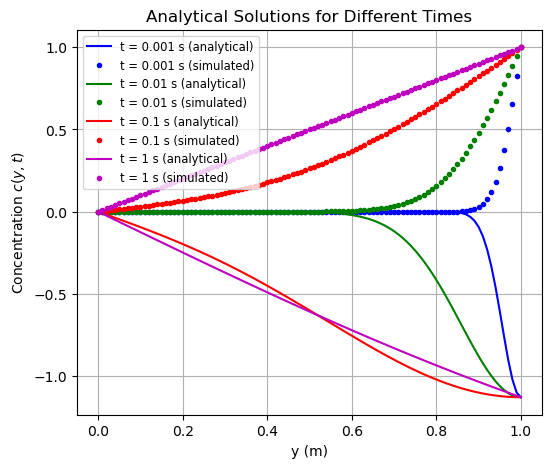

In [12]:
# Analytical solution function
@jit(nopython=True)
def erfc_numba(x):
    return 1 - (2 / np.sqrt(np.pi)) * np.exp(-x**2)

@jit(nopython=True)
def analytical_solution(y, t, D, n_terms=50):
    result = np.zeros_like(y)
    for i in range(n_terms):
        result += erfc_numba((1 - y + 2*i) / (2 * np.sqrt(D * t))) - erfc_numba((1 + y + 2*i) / (2 * np.sqrt(D * t)))
    return result
    
# Plot settings
plt.close('all')
y_values = np.linspace(0, 1, N+1)
times = [0.001, 0.01, 0.1, 1]  # Different times at which c(y) is plotted

# Plot the analytical solutions for various times
plt.figure(figsize=(6, 5))
colors = ['b', 'g', 'r', 'm']
for index, t in enumerate(times):
    # Plot the analytical solution
    plt.plot(y_values, analytical_solution(y_values, t, D), label=f't = {t} s (analytical)', color=colors[index])
    # Plot the simulated solution
    idx4con = np.ceil(t * len(concentrations) / total_time - 1).astype(int)
    idx4con = min(len(concentrations) - 1, max(0, idx4con)) # Limit the index boundary
    c = concentrations[idx4con]
    plt.plot(y_values, c[0, :], 'o', label=f't = {t} s (simulated)', markersize=3, color=colors[index])


plt.xlabel('y (m)')
plt.ylabel(r'Concentration $c(y, t)$')
plt.title('Analytical Solutions for Different Times')
plt.legend(fontsize='small')
plt.grid(True)
plt.savefig(os.path.join('image', 'E.png'), dpi=300)
plt.show()

## F (1 point) 
Plot the results, show the 2D domain, with a color representing the
concentration at each point. Make a plot of the state of the system at several times: $t$ = {0, 0.001, 0.01, 0.1, and 1}.

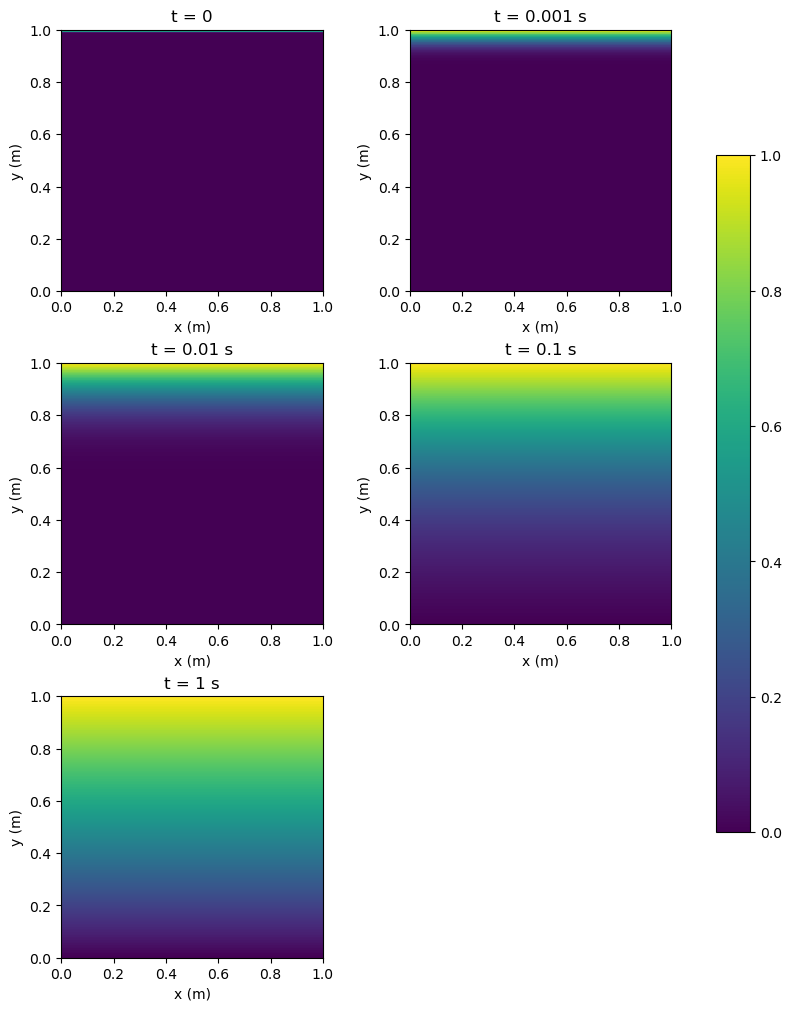

In [14]:
# Define the time points for visualization
times_to_plot = [0, 0.001, 0.01, 0.1, 1]  # Given times

# Initialize figure with better layout management
fig, axes = plt.subplots(3, 2, figsize=(8, 10), constrained_layout=True)

# Plot initial condition (t=0)
c = np.zeros((N+1, N+1))
c[:, N] = 1.0  # Set top boundary condition
im = axes[0, 0].imshow(c.T, extent=(0, 1, 0, 1), origin='lower', cmap=cm.viridis)
axes[0, 0].set_title(f't = 0')

# Loop through given times and plot
for index, t in enumerate(times_to_plot[1:]):  # Skip first time (0)
    idx4con = min(len(concentrations) - 1, max(0, np.ceil(t * len(concentrations) / total_time - 1).astype(int)))
    c = concentrations[idx4con]

    # Determine subplot position
    row, col = divmod(index + 1, 2)

    # Plot the data
    im = axes[row, col].imshow(c.T, extent=(0, 1, 0, 1), origin='lower', cmap=cm.viridis)
    axes[row, col].set_title(f't = {t} s')

# Remove last empty subplot if necessary
if len(times_to_plot) % 2 != 0:
    fig.delaxes(axes[-1, -1])

# Add a single colorbar to the figure
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.05, shrink=0.8)

# Set x and y labels
for ax in axes.flat:
    ax.set(xlabel='x (m)', ylabel='y (m)')

plt.savefig(os.path.join('image', 'F.png'), dpi=300)
plt.show()

## G (1 point) 
Make an animated plot of the time dependent diffusion equation until
equilibrium.

In [16]:
# Detect equilibrium time
frames_per_save = int(total_time / dt) // len(concentrations)
equil_time = 0.0
for i in range(1, len(concentrations)):
    if np.allclose(concentrations[i], concentrations[i-1], atol=1e-10):
        equil_time = i * dt * frames_per_save
        break
equil_time /= 2
print(f"Equilibrium time after correction: {equil_time:.3f} s")

Equilibrium time after correction: 0.385 s


Animation will stop at 0.385s, using 385 frames.


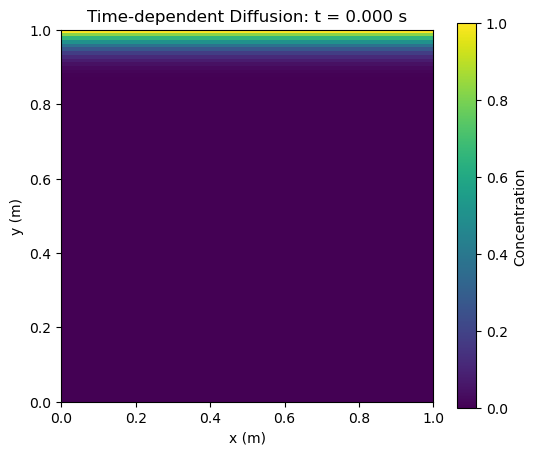

In [17]:
# Calculate the required number of frames
frames_num = np.ceil(equil_time / total_time * len(concentrations)).astype(int)
frames_num = min(frames_num, len(concentrations))  # Prevent out-of-range errors

print(f"Animation will stop at {equil_time:.3f}s, using {frames_num} frames.")

# Set up the animation figure
fig, ax = plt.subplots(figsize=(6, 5))

# Initialize colormap
im = ax.imshow(concentrations[0].T, extent=(0, 1, 0, 1), origin='lower', cmap=cm.viridis)
ax.set_title("Time-dependent Diffusion")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

# Add colorbar
cbar = fig.colorbar(im)
cbar.set_label("Concentration")

# Update function
def update(frame):
    im.set_array(concentrations[frame].T)  # Update concentration data
    ax.set_title(f"Time-dependent Diffusion: t = {frame * equil_time / frames_num:.3f} s")  # Display only up to 0.39s
    return [im]

# Create animation
ani = animation.FuncAnimation(fig, update, frames=frames_num, interval=50, blit=False)

# Save GIF and MP4
ani.save("image/diffusion_simulation_G.gif", writer="pillow", fps=60)
ani.save("video/diffusion_simulation_G.mp4", writer="ffmpeg", fps=60)

---

## H (1 point) 
Implement the Jacobi iteration, the Gauss-Seidel method and SOR.
Try $N = 50$. Test the methods by comparing the result to the analytical result in
eq. (5), i.e. the linear dependence of the concentration on $y$.

## I (1 point) 
Show how the convergence measure $δ$ in eq. (14) depends on the number
of iterations $k$ for each of the methods. A log-lin plot may be suitable. For SOR,
choose a few representative values for $ω$.

## J (1 point) 
In the SOR method, find the optimal $ω$. How does it depend on $N$ ?.
So far we have only looked at diffusion in a rather dull domain. Now that we have
an efficient iterative solver available, it’s time to start including some object into the
domain. So, now we assume that within our computational domain we include say
a square object. We assume that the object is a sink for the diffusion concentration,
that is, the concentration is zero everywhere on the object.

## K (2 point) 
Implement the possibility to include objects into the computational
domain. The objects should be sinks. Experiment a little bit with some objects in
the computational domain (e.g. a rectangle or a few rectangles, ...). What is the
influence on the number of iterations. What about the optimal $ω$ , is it influenced
by the presence of objects? Look at the resulting concentration fields, and try to
interpret what happens. The implementation in this exercise will also be used for
diffusion-limited aggregation in Set 2.

Hint: For the iterations, the presence of the objects is not complicated. If a point
$(i, j)$ is part of an object, the concentration is just 0, and an iteration is not necessary
(i.e., the new value is also 0). Therefore, you must implement some easy encoding
of the object in the computational grid, and during the iterations simply test if the
grid point that you are updating is part of the object or not. If not, you apply the
SOR rule, if yes, just put the new value to zero. The easiest encoding is just an
extra array of integers, where e.g. a one-value would code for the presence of an
object, and a zero value for the absence of an object.

## Optional (1 point) 
Think of a way to incorporate objects with insulating material
in your domain. What changes in the time evolution of the system? And in the
final state?